# Event detection with Recurrent Neural Networks - Part 3

In this fifth lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will use different types of Recurrent Neural Networks to detect events in noisy seismic recordings. 

This is the third part of our lab where we change the input dataset from the original time series to its STFT.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import io
import os
import glob
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from einops import rearrange
from scipy.signal import spectrogram, stft
from tqdm.notebook import tqdm_notebook as tqdm
from torch.utils.data import TensorDataset, DataLoader 
from sklearn.metrics import accuracy_score, classification_report

import datacreation as dc

In [2]:
def set_seed(seed):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

Let's begin by checking we have access to a GPU and tell Torch we would like to use it:

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
set_seed(40)

True

Finally we set a flag that chooses whether we want to train our networks or load pre-trained ones. 

In this lab we will first train our networks and later simply load them if we want to just do some predictions on new data.

In [5]:
loadmodel = False
modelsdir = './'

## Data creation

To begin with we need to create a large variety of training data. Each training pair will be composed of a seismic trace and a trigger trace, where the latter is equal 1 in correspondance of the seismic event and 0 elsewhere.

The seismic trace is created as follows:

$$
s(t) = a * w(t;f) * r(t;t_0) + n(t, SNR)
$$

where the central frequency of the wavelet $f$, the time of the event $t_0$, and $SNR$ are randomly chosen for each trace. Moreover, some of the traces contain only noise, this is driven by the $a$ parameter. 

In [6]:
# Input paramters
nt = 500 # number of time samples
dt = 0.002 # time sampling
#SNR = [5., 10., -1., 4.] # signal to noise ratio paramters (min, max, skewness, mean) - low noise level
SNR = [2., 8., 4., 3.] # signal to noise ratio paramters (min, max, skewness, mean) - high noise level
noise_freq = [2, 40] # min and max frequency of noise
wavelet_freq = [20, 30] # min and max frequency of wavelet
nfft = 1024 # STFT frequency samples
nperseg = 50 # STFT samples per window
noverlap = 46 # STFT overlap

ntraining = 500 # number of training samples
ntest = 50 # number of test samples

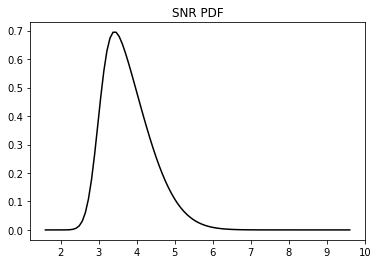

In [7]:
# Display SNR
plt.plot(*dc.pdf_snr(*SNR), 'k')
plt.title('SNR PDF');

In [8]:
# Create data
traindata = [dc.create_data(nt=nt, dt=dt,
                            snrparams=SNR, 
                            freqwav=wavelet_freq, 
                            freqbp=noise_freq, 
                            signal=True) 
             for i in tqdm(range(ntraining))]

testdata = [dc.create_data(nt=nt, dt=dt,
                           snrparams=SNR, 
                           freqwav=wavelet_freq, 
                           freqbp=noise_freq, 
                           signal=True) 
            for i in tqdm(range(ntest))]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Let's identify the STFT strategy

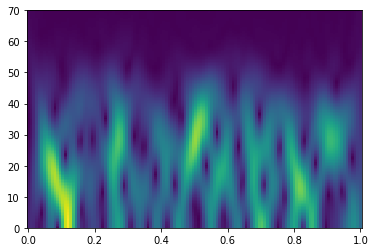

In [9]:
fsp, tsp, Sxx = stft(traindata[0]['synthetic'], 1/dt, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

plt.figure()
plt.pcolormesh(tsp, fsp, np.abs(Sxx), shading='nearest')
plt.ylim(0,70);

In [10]:
train_data_X = np.zeros([ntraining, nt, 1])
train_data_y = np.zeros([ntraining, nt])

for i, d in enumerate(traindata):  
    train_data_X[i, :, 0] = d['synthetic']
    train_data_y[i, :] = d['labels']

In [11]:
test_data_X = np.zeros([ntest, nt, 1])
test_data_y = np.zeros([ntest, nt])

for i, d in enumerate(testdata):  
    test_data_X[i, :, 0] = d['synthetic']
    test_data_y[i, :] = d['labels']

In [12]:
nfstft, ntstft = np.sum(fsp<60), len(tsp)
train_data_Xstft = np.zeros([ntraining, ntstft, nfstft])
train_data_ystft = np.zeros([ntraining, ntstft])

for i, d in enumerate(traindata):  
    train_data_Xstft[i, :] = np.abs(stft(d['synthetic'], 1/dt, nperseg=nperseg, noverlap=noverlap, nfft=nfft)[2][:nfstft].T)
    label_stft = np.abs(stft(d['labels'], 1/dt, nperseg=nperseg, noverlap=noverlap, nfft=nfft)[2][:nfstft].T)
    label_stft = np.sum(label_stft, axis=1)
    label_stft /= label_stft.max()
    label_stft[label_stft>0.5] = 1
    label_stft[label_stft<=0.5] = 0
    train_data_ystft[i, :] = label_stft

In [13]:
test_data_Xstft = np.zeros([ntest, ntstft, nfstft])
test_data_ystft = np.zeros([ntest, ntstft])

for i, d in enumerate(testdata):  
    test_data_Xstft[i, :] = np.abs(stft(d['synthetic'], 1/dt, nperseg=nperseg, noverlap=noverlap, nfft=nfft)[2][:nfstft].T)
    label_stft = np.abs(stft(d['labels'], 1/dt, nperseg=nperseg, noverlap=noverlap, nfft=nfft)[2][:nfstft].T)
    label_stft = np.sum(label_stft, axis=1)
    label_stft /= label_stft.max()
    label_stft[label_stft>0.5] = 1
    label_stft[label_stft<=0.5] = 0
    test_data_ystft[i, :] = label_stft

In [14]:
# percentage of 0 labels over 1 labels
scaling = np.round(np.mean([(nt-np.sum(traindata[i]['labels']))/np.sum(traindata[i]['labels']) for i in range(ntraining)]))
scaling

11.0

Let's take a look at the data we are going to work with

In [15]:
def plotting(X1, y1, X2, y2, title1, title2, y1prob=None, y2prob=None, dt=0.002, nplot=3):
    fig, axs = plt.subplots(nplot, 2, figsize=[15, nplot*2])
    nt = len(X1[0])
    for t in range(nplot):
        axs[t, 0].set_title(title1)
        axs[t, 0].plot(np.arange(nt)*dt, X1[t].squeeze(),'k')
        axs[t, 0].fill_between(np.arange(nt)*dt,
                               y1=1*y1[t].squeeze(), 
                               y2=-1*y1[t].squeeze(),
                               linewidth=0.0,
                               color='#E6DF44')
        if y1prob is not None:
            axs[t, 0].plot(np.arange(nt)*dt, y1prob[t].squeeze(), '#E6DF44', lw=2)

        axs[t, 1].set_title(title2)
        axs[t, 1].plot(np.arange(nt)*dt, X2[t].squeeze(),'k')
        axs[t, 1].fill_between(np.arange(nt)*dt,
                               y1=1*y2[t].squeeze(), 
                               y2=-1*y2[t].squeeze(),
                               linewidth=0.0,
                               color='#A2C523')
        if y2prob is not None:
            axs[t, 1].plot(np.arange(nt)*dt, y2prob[t].squeeze(), '#A2C523', lw=2)

    for ax in axs.ravel():
        ax.set_xlim([0,dt*nt])
        ax.set_ylim([-1,1])

    fig.tight_layout()
    

def plotting_stft(X, Xstft, y, ystft, tstft, fstft, ypred=None, yprob=None, ystftprob=None, dt=0.002, nplot=3):
    fig, axs = plt.subplots(nplot, 2, figsize=[15, nplot*2])
    nt = len(X[0])
    for t in range(nplot):
        axs[t, 0].plot(np.arange(nt)*dt, X[t].squeeze(),'k')
        axs[t, 0].fill_between(np.arange(nt)*dt,
                               y1=1*y[t].squeeze(), 
                               y2=-1*y[t].squeeze(),
                               linewidth=0.0,
                               color='#E6DF44')
        axs[t, 1].pcolormesh(tstft, fstft, Xstft[t].T, shading='nearest')
        axs[t, 1].fill_between(tstft, np.zeros_like(tstft), ystft[t]*fstft[-1], 
                               linewidth=1.0, color='#E6DF44', alpha=0.4)
        if ypred is not None:
            axs[t, 0].fill_between(np.arange(nt)*dt,
                                   y1=1*ypred[t].squeeze(), 
                                   y2=-1*ypred[t].squeeze(),
                                   linewidth=0.0, alpha=0.4,
                                   color='#A2C523')
        if yprob is not None:
            axs[t, 0].plot(np.arange(nt)*dt, yprob[t].squeeze(), '#A2C523', lw=3)
        if ystftprob is not None:
            axs[t, 1].plot(tstft, ystftprob[t].squeeze()*fstft[-1], '#A2C523', lw=3)
            axs[t, 1].axhline(fstft[-1]/2, color='#A2C523', lw=1, linestyle='--')

    for ax in axs[:, 0].ravel():
        ax.set_xlim([0,dt*nt])
        ax.set_ylim([-1,1])

    fig.tight_layout()

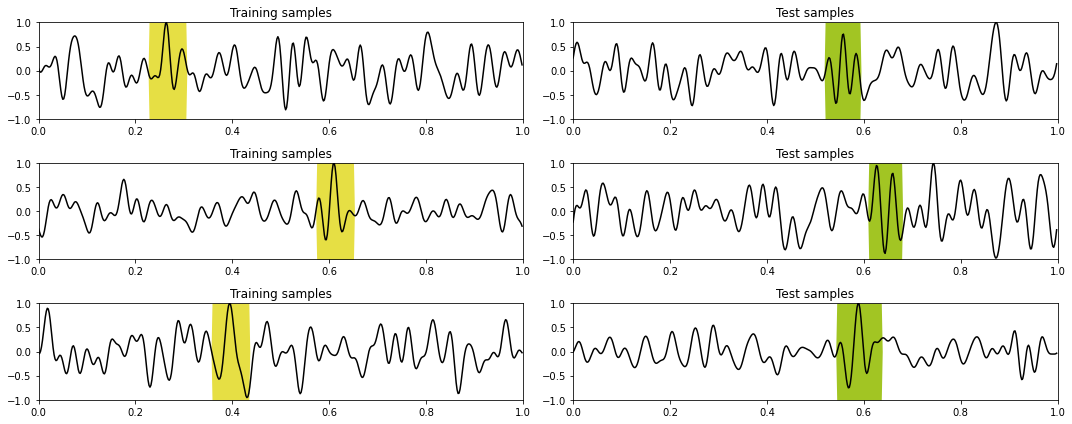

In [16]:
nplot = 3
plotting(train_data_X, train_data_y, test_data_X, test_data_y, 
         'Training samples', 'Test samples', dt=dt, nplot=3)

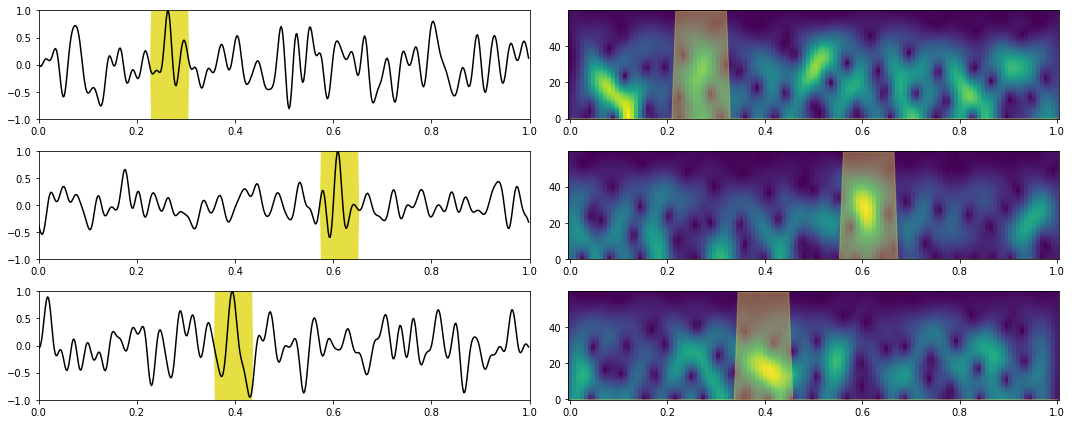

In [17]:
nplot = 3
plotting_stft(train_data_X, train_data_Xstft, train_data_y, train_data_ystft, tsp, fsp[:nfstft], dt=dt, nplot=3)

## Training

Let's now prepare some training routines similar to those we have already seen in the other labs.

In [18]:
def train(model, criterion, optimizer, data_loader, device='cpu'):
    model.train()
    accuracy = 0
    loss = 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)            
        optimizer.zero_grad()
        yprob = model(X)[0]
        ls = criterion(yprob.view(-1), y.view(-1))
        ls.backward()
        optimizer.step()
        with torch.no_grad(): # use no_grad to avoid making the computational graph...
            y_pred = np.where(nn.Sigmoid()(yprob.detach()).cpu().numpy() > 0.5, 1, 0).astype(np.float32)
        loss += ls.item()
        accuracy += accuracy_score(y.cpu().numpy().ravel(), y_pred.ravel())
    loss /= len(data_loader)
    accuracy /= len(data_loader)
    return loss, accuracy

In [19]:
def evaluate(model, criterion, data_loader, device='cpu'):
    model.eval()
    accuracy = 0
    loss = 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)            
        with torch.no_grad(): # use no_grad to avoid making the computational graph...
            yprob = model(X)[0]
            ls = criterion(yprob.view(-1), y.view(-1))
        y_pred = np.where(nn.Sigmoid()(yprob.detach()).cpu().numpy() > 0.5, 1, 0).astype(np.float32)
        loss += ls.item()
        accuracy += accuracy_score(y.cpu().numpy().ravel(), y_pred.ravel())
    loss /= len(data_loader)
    accuracy /= len(data_loader)
    return loss, accuracy

In [20]:
def predict(model, X, y, Xstft, ystft, label, device='cpu', dt=0.002, nplot=5, report=False):
    model.eval()
    Xstft = Xstft.to(device)

    with torch.no_grad(): # use no_grad to avoid making the computational graph...
        yprob = nn.Sigmoid()(model(Xstft)[0])
    y_pred = np.where(yprob.cpu().numpy() > 0.5, 1, 0)
    
    if report:
        print(classification_report(ystft.ravel(), y_pred.ravel()))
    
    # create time prediction
    nt = X.shape[1]
    yprob_time = np.vstack([np.interp(np.arange(nt)*dt, tsp, yprob.cpu().numpy()[i]) for i in range(X.shape[0])])
    y_pred_time = np.where(yprob_time > 0.5, 1, 0)
    
    plotting_stft(X.cpu().detach().numpy().squeeze(), 
                  Xstft.cpu().detach().numpy().squeeze(), 
                  y, ystft, tsp, fsp[:nfstft], ypred=y_pred_time,
                  yprob=yprob_time, ystftprob=yprob, dt=dt, nplot=nplot)

In [21]:
def training(network, loss, optim, nepochs, train_loader, test_loader, 
             device='cpu', modeldir=None, modelname=''):
    iepoch_best = 0
    train_loss_history = np.zeros(nepochs)
    valid_loss_history = np.zeros(nepochs)
    train_acc_history = np.zeros(nepochs)
    valid_acc_history = np.zeros(nepochs)
    for i in range(nepochs):
        train_loss, train_accuracy = train(network, loss, optim, 
                                           train_loader, device=device)
        valid_loss, valid_accuracy = evaluate(network, loss, 
                                              test_loader, device=device)
        train_loss_history[i] = train_loss
        valid_loss_history[i] = valid_loss
        train_acc_history[i] = train_accuracy
        valid_acc_history[i] = valid_accuracy
        if modeldir is not None:
            if i == 0 or valid_accuracy > np.max(valid_acc_history[:i]):        
                iepoch_best = i
                torch.save(network.state_dict(), os.path.join(modeldir, 'models', model+'.pt'))
        if i % 10 == 0:
            print(f'Epoch {i}, Training Loss {train_loss:.3f}, Training Accuracy {train_accuracy:.3f}, Test Loss {valid_loss:.3f}, Test Accuracy {valid_accuracy:.3f}')
    return train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best

Similarly we define the network we are going to use

In [22]:
class BiLSTMNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(BiLSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(I, H, 1, batch_first=True, bidirectional=True)
        self.dense = nn.Linear(2*H, O, bias=False)
        
    def forward(self, x):
        z, _ = self.lstm(x)
        out = self.dense(z)
        return out.squeeze(), None

We are finally ready to prepare the training and test data

In [23]:
# Define Train Set
X_train = torch.from_numpy(train_data_Xstft).float()
y_train = torch.from_numpy(train_data_ystft).float()

train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_test = torch.from_numpy(test_data_Xstft).float()
y_test = torch.from_numpy(test_data_ystft).float()

test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### BidirLSTM

Epoch 0, Training Loss 1.446, Training Accuracy 0.115, Test Loss 1.411, Test Accuracy 0.113
Epoch 10, Training Loss 0.637, Training Accuracy 0.892, Test Loss 0.555, Test Accuracy 0.906
Epoch 20, Training Loss 0.404, Training Accuracy 0.920, Test Loss 0.408, Test Accuracy 0.913
Epoch 30, Training Loss 0.322, Training Accuracy 0.930, Test Loss 0.357, Test Accuracy 0.948
Epoch 40, Training Loss 0.300, Training Accuracy 0.934, Test Loss 0.302, Test Accuracy 0.949
Epoch 50, Training Loss 0.254, Training Accuracy 0.948, Test Loss 0.313, Test Accuracy 0.947
Epoch 60, Training Loss 0.238, Training Accuracy 0.944, Test Loss 0.264, Test Accuracy 0.961
Epoch 70, Training Loss 0.220, Training Accuracy 0.953, Test Loss 0.269, Test Accuracy 0.958
Epoch 80, Training Loss 0.218, Training Accuracy 0.954, Test Loss 0.250, Test Accuracy 0.958
Epoch 90, Training Loss 0.212, Training Accuracy 0.954, Test Loss 0.237, Test Accuracy 0.961
Best epoch: 95, Valid accuracy: 0.96


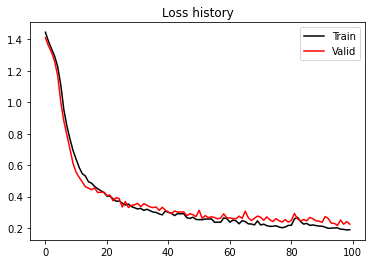

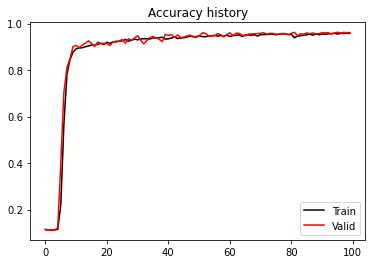

In [24]:
model = 'bilstm_stft'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network_stft = BiLSTMNetwork(nfstft, 200, 1)
    network_stft.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network_stft.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network_stft, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

# Load best model
network_stft = BiLSTMNetwork(nfstft, 200, 1)
network_stft.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
network_stft.to(device)
    
print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      1116
         1.0       0.72      0.98      0.83       144

    accuracy                           0.95      1260
   macro avg       0.86      0.97      0.90      1260
weighted avg       0.97      0.95      0.96      1260



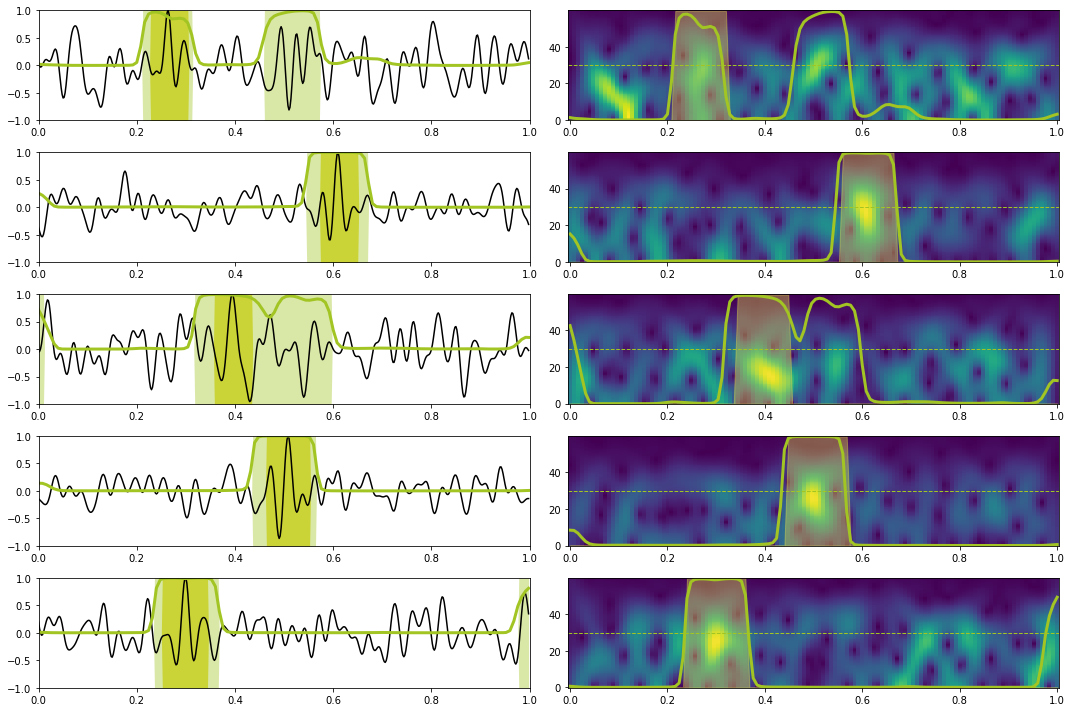

In [25]:
# Prediction train
X, y = torch.from_numpy(train_data_X[:10]).float().to(device), torch.from_numpy(train_data_y[:10]).float().to(device)
Xstft, ystft = torch.from_numpy(train_data_Xstft[:10]).float().to(device), torch.from_numpy(train_data_ystft[:10]).float().to(device)

predict(network_stft, X, y, Xstft, ystft, model, device, dt=dt, nplot=5, report=True)

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      1117
         1.0       0.82      0.99      0.90       143

    accuracy                           0.97      1260
   macro avg       0.91      0.98      0.94      1260
weighted avg       0.98      0.97      0.97      1260



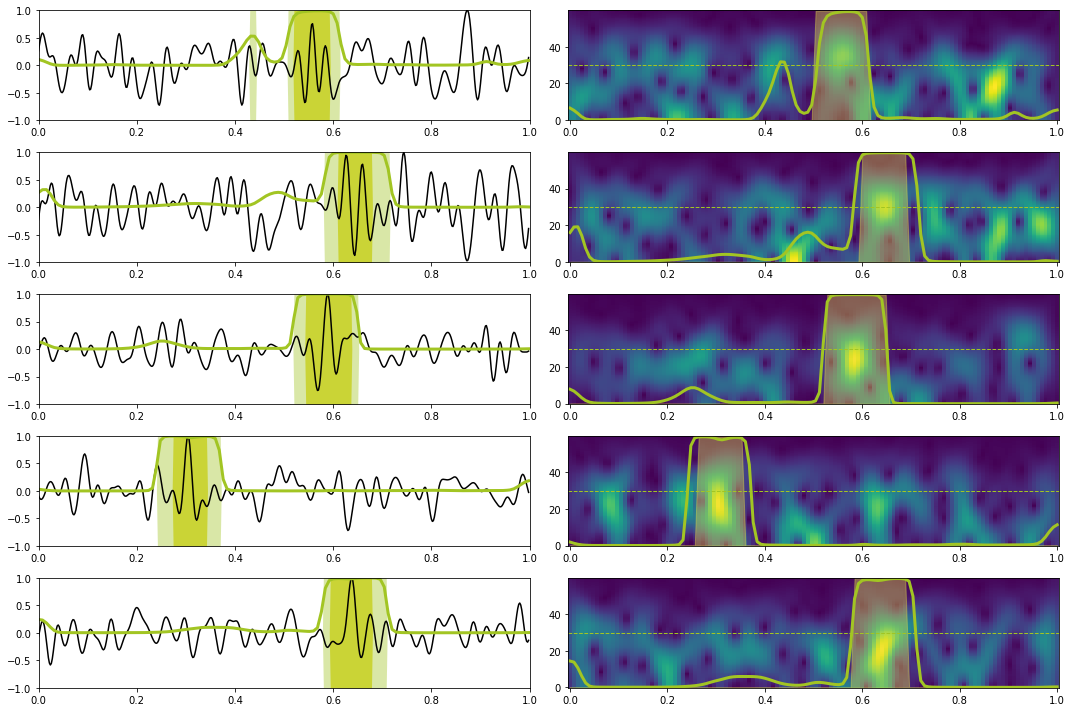

In [26]:
# Prediction test
X, y = torch.from_numpy(test_data_X[:10]).float().to(device), torch.from_numpy(test_data_y[:10]).float().to(device)
Xstft, ystft = torch.from_numpy(test_data_Xstft[:10]).float().to(device), torch.from_numpy(test_data_ystft[:10]).float().to(device)

predict(network_stft, X, y, Xstft, ystft, model, device, dt=dt, nplot=5, report=True)

### BidirLSTM + Self-Attention with positional encoding

Finally we will be using the implementation of self-attention in the [self-attention-cv](https://github.com/The-AI-Summer/self-attention-cv) library. However, since we want to look at the attention weights we need to make some small modifications to the original code base as shown below.

In [27]:
def compute_mhsa(q, k, v, scale_factor=1, mask=None):
    # resulted shape will be: [batch, heads, tokens, tokens]
    scaled_dot_prod = torch.einsum('... i d , ... j d -> ... i j', q, k) * scale_factor

    if mask is not None:
        assert mask.shape == scaled_dot_prod.shape[2:]
        scaled_dot_prod = scaled_dot_prod.masked_fill(mask, -np.inf)

    attention = torch.softmax(scaled_dot_prod, dim=-1)
    # calc result per head
    return torch.einsum('... i j , ... j d -> ... i d', attention, v), attention


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=None):
        """
        Implementation of multi-head attention layer of the original transformer model.
        einsum and einops.rearrange is used whenever possible
        Args:
            dim: token's dimension, i.e. word embedding vector size
            heads: the number of distinct representations to learn
            dim_head: the dim of the head. In general dim_head<dim.
            However, it may not necessary be (dim/heads)
        """
        super().__init__()
        self.dim_head = (int(dim / heads)) if dim_head is None else dim_head
        _dim = self.dim_head * heads
        self.heads = heads
        self.to_qvk = nn.Linear(dim, _dim * 3, bias=False)
        self.W_0 = nn.Linear(_dim, dim, bias=False)
        self.scale_factor = self.dim_head ** -0.5

    def forward(self, x, mask=None):
        assert x.dim() == 3
        qkv = self.to_qvk(x)  # [batch, tokens, dim*3*heads ]

        # decomposition to q,v,k and cast to tuple
        # the resulted shape before casting to tuple will be: [3, batch, heads, tokens, dim_head]
        q, k, v = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.heads))

        out, attention = compute_mhsa(q, k, v, mask=mask, scale_factor=self.scale_factor)

        # re-compose: merge heads with dim_head
        out = rearrange(out, "b h t d -> b t (h d)")
        # Apply final linear transformation layer
        return self.W_0(out), attention

In [28]:
def position_encoding(seq_len, dim_model, device=torch.device("cpu")):
    pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = pos / 1e4 ** (dim // dim_model)
    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

In [29]:
class SelfAttentionPosEncNetwork(nn.Module):
    def __init__(self, I, He, Hd, O, seqlen, device=torch.device("cpu")):
        super(SelfAttentionPosEncNetwork, self).__init__()
        self.encoder = nn.LSTM(I, He, 1, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(dim=2*He)
        self.decoder = nn.LSTM(2*He, Hd, batch_first=True, bidirectional=True)
        self.dense = nn.Linear(2*Hd, O, bias=False)
        self.posenc = position_encoding(seqlen, I, device)
        
    def forward(self, x):
        # Positional encoding
        x = x + self.posenc
        # Encoder
        z, _ = self.encoder(x)
        # Attention+Decoder
        z1, attention = self.attention(z)
        z2, _ = self.decoder(z)
        # Dense
        out = self.dense(z2)
        return out.squeeze(), attention

Epoch 0, Training Loss 1.448, Training Accuracy 0.218, Test Loss 1.419, Test Accuracy 0.113
Epoch 10, Training Loss 0.494, Training Accuracy 0.897, Test Loss 0.414, Test Accuracy 0.924
Epoch 20, Training Loss 0.325, Training Accuracy 0.931, Test Loss 0.283, Test Accuracy 0.921
Epoch 30, Training Loss 0.280, Training Accuracy 0.939, Test Loss 0.243, Test Accuracy 0.956
Epoch 40, Training Loss 0.270, Training Accuracy 0.941, Test Loss 0.239, Test Accuracy 0.944
Epoch 50, Training Loss 0.216, Training Accuracy 0.949, Test Loss 0.224, Test Accuracy 0.953
Epoch 60, Training Loss 0.199, Training Accuracy 0.954, Test Loss 0.237, Test Accuracy 0.960
Epoch 70, Training Loss 0.210, Training Accuracy 0.949, Test Loss 0.223, Test Accuracy 0.966
Epoch 80, Training Loss 0.169, Training Accuracy 0.960, Test Loss 0.240, Test Accuracy 0.958
Epoch 90, Training Loss 0.238, Training Accuracy 0.945, Test Loss 0.215, Test Accuracy 0.957
Best epoch: 51, Valid accuracy: 0.97


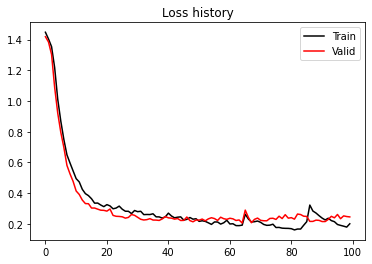

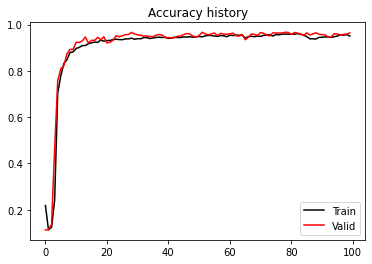

In [30]:
model = 'selfatt_stft'
nepochs = 100
set_seed(40)

if not loadmodel:
    # Train
    network_stft = SelfAttentionPosEncNetwork(nfstft, 200, 100, 1, ntstft, device)
    network_stft.to(device)

    bce_loss_weight = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([scaling, ]).to(device))
    optim = torch.optim.Adam(network_stft.parameters(), lr=1e-4)

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history, iepoch_best = \
        training(network_stft, bce_loss_weight, optim, nepochs, train_loader, test_loader,
                 device=device, modeldir=modelsdir, modelname=model)
    
    np.savez(os.path.join(modelsdir, 'models', model + '_trainhistory'), 
             train_loss_history=train_loss_history,
             valid_loss_history=valid_loss_history,
             train_acc_history=train_acc_history,
             valid_acc_history=valid_acc_history,
             iepoch_best=iepoch_best)
else:
    fhist = np.load(os.path.join(modelsdir, 'models', model + '_trainhistory.npz'))
    train_loss_history = fhist['train_loss_history']
    valid_loss_history = fhist['valid_loss_history']
    train_acc_history = fhist['train_acc_history']
    valid_acc_history = fhist['valid_acc_history']
    iepoch_best = fhist['iepoch_best']

# Load best model
network_stft = SelfAttentionPosEncNetwork(nfstft, 200, 100, 1, ntstft, device)
network_stft.load_state_dict(torch.load(os.path.join(modelsdir, 'models', model+'.pt')))
network_stft.to(device)
    
print('Best epoch: %d, Valid accuracy: %.2f' % (iepoch_best, valid_acc_history[iepoch_best]))

plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(valid_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_acc_history, 'k', label='Train')
plt.plot(valid_acc_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1116
         1.0       0.81      0.97      0.88       144

    accuracy                           0.97      1260
   macro avg       0.90      0.97      0.93      1260
weighted avg       0.97      0.97      0.97      1260



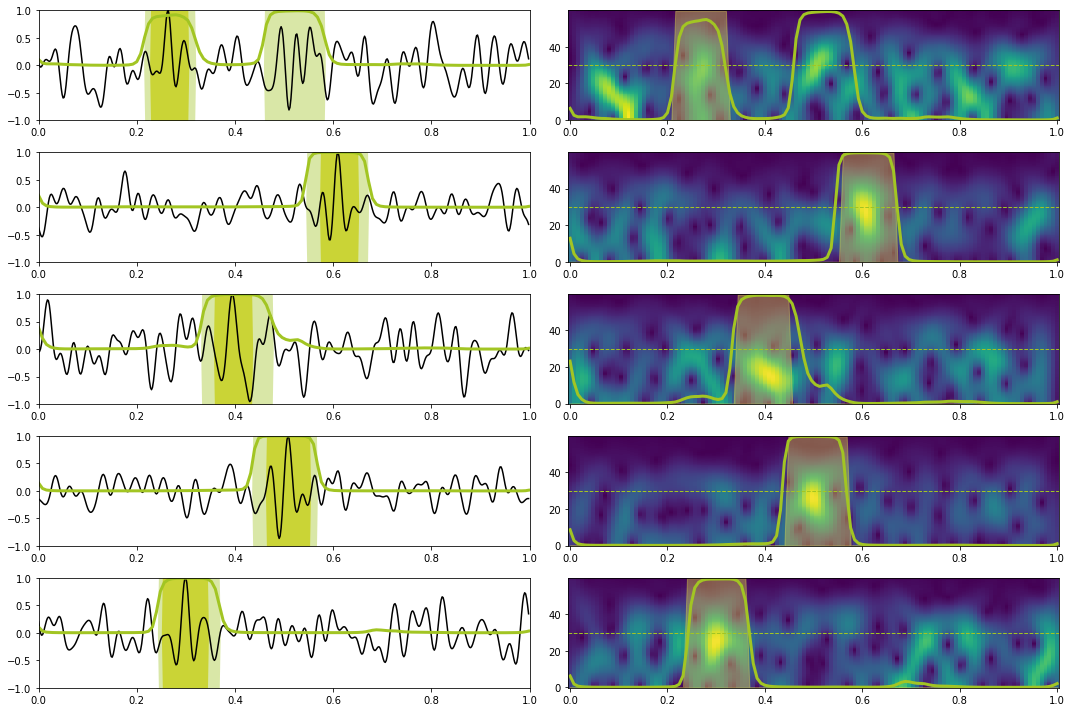

In [31]:
# Prediction train
X, y = torch.from_numpy(train_data_X[:10]).float().to(device), torch.from_numpy(train_data_y[:10]).float().to(device)
Xstft, ystft = torch.from_numpy(train_data_Xstft[:10]).float().to(device), torch.from_numpy(train_data_ystft[:10]).float().to(device)

predict(network_stft, X, y, Xstft, ystft, model, device, dt=dt, nplot=5, report=True)

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      1117
         1.0       0.74      0.98      0.84       143

    accuracy                           0.96      1260
   macro avg       0.87      0.97      0.91      1260
weighted avg       0.97      0.96      0.96      1260



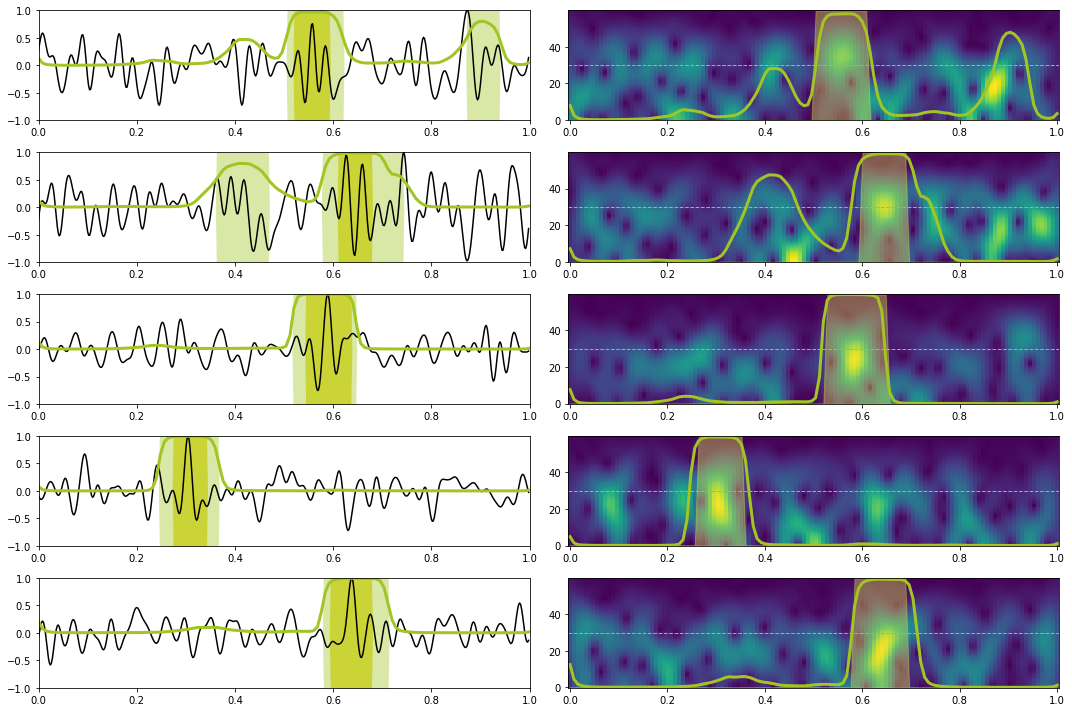

In [32]:
# Prediction test
X, y = torch.from_numpy(test_data_X[:10]).float().to(device), torch.from_numpy(test_data_y[:10]).float().to(device)
Xstft, ystft = torch.from_numpy(test_data_Xstft[:10]).float().to(device), torch.from_numpy(test_data_ystft[:10]).float().to(device)

predict(network_stft, X, y, Xstft, ystft, model, device, dt=dt, nplot=5, report=True)

Let's now look at the attention weights for a single test sample

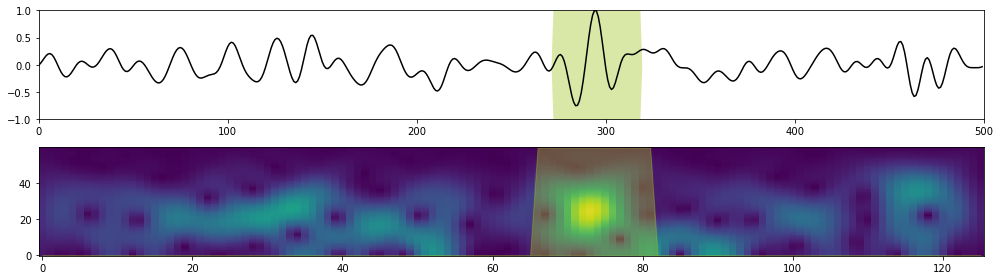

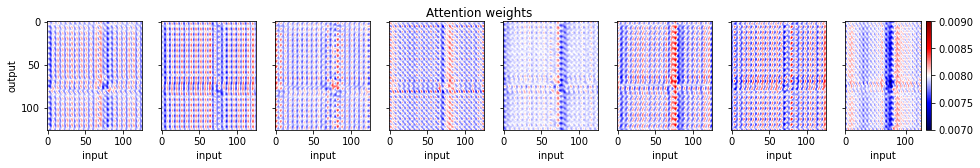

In [54]:
isample = 2
X = torch.from_numpy(test_data_X[isample:isample+1]).float().to(device)
y = torch.from_numpy(test_data_y[isample:isample+1]).float().to(device)
Xstft = torch.from_numpy(test_data_Xstft[isample:isample+1]).float().to(device)
ystft = torch.from_numpy(test_data_ystft[isample:isample+1]).float().to(device)

network_stft.eval()
X = X.to(device)
with torch.no_grad():
    _, attentionw = network_stft(Xstft)

fig, axs = plt.subplots(2, 1, figsize=(14, 4))
axs[0].plot(np.arange(nt), X.squeeze(), 'k')
axs[0].fill_between(np.arange(nt),
                    y1=1*y.squeeze(), 
                    y2=-1*y.squeeze(),
                    linewidth=0.0, alpha=0.4,
                    color='#A2C523')
axs[0].set_xlim(0, nt)
axs[0].set_ylim(-1, 1)
axs[1].pcolormesh(np.arange(ntstft), fsp[:nfstft], Xstft.squeeze().T, shading='nearest')
axs[1].fill_between(np.arange(ntstft), np.zeros(ntstft), ystft.squeeze()*fsp[:nfstft][-1], 
                    linewidth=1.0, alpha=0.4,
                    color='#A2C523')

plt.tight_layout()

fig, axs = plt.subplots(1, 8, sharey=True, figsize=(16, 2))
fig.suptitle('Attention weights')
for iatt in range(8):
    im = axs[iatt].imshow(attentionw.squeeze()[iatt].detach().cpu().numpy(), 
                          cmap='seismic',
                          vmin=0.007, vmax=0.009)
    axs[iatt].axis('tight')
    axs[iatt].set_xlabel('input')
axs[0].set_ylabel('output')
fig.colorbar(im, ax=axs[iatt]);